# Embeddings Analysis

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import distinctipy
import os
from datasets import load_from_disk, Split
from cuml import TSNE
from ettcl.encoding import ColBERTEncoder
from ettcl.utils import Checkpoint

seaborn.set_theme(style="dark")

output_dir = "outputs"
dataset_path = "~/data/trec-6"
text_column = "text"
label_column = "label"

In [2]:
dataset = load_from_disk(os.path.expanduser(dataset_path))
dataset.set_format("torch")

train_dataset = dataset[Split.TRAIN]
# train_dataset = train_dataset.train_test_split(train_size=500, stratify_by_column='label')['train']
test_dataset = dataset[Split.TEST]

train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 4906
})

## ColBERT (finetuned)

In [4]:
# checkpoint = Checkpoint("/home/IAIS/hiser/dev/hyped/examples/output/trec_50_bert/model/best-model")
# encoder = ColBERTEncoder.from_pretrained(checkpoint.best)
encoder = ColBERTEncoder.from_pretrained("/home/IAIS/hiser/dev/hyped/examples/output/trec_6_bert/model/best-model")

Some weights of the model checkpoint at /home/IAIS/hiser/dev/hyped/examples/output/trec_50_bert/model/best-model were not used when initializing ColBERTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ColBERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
encoder.cuda()
embeddings, doc_lengths = encoder.encode_passages(train_dataset["text"], to_cpu=True)
encoder.cpu()

embedding_labels = torch.cat([torch.full((doc_length,), label) for label, doc_length in zip(train_dataset["label"], doc_lengths)])
doc_ids = torch.cat([torch.full((doc_length,), i) for i, doc_length in enumerate(doc_lengths)])

print("embeddings", embeddings.shape)
print("embedding_labels", embedding_labels.shape)
print("doc_ids", doc_ids.shape)

Encoding:   0%|          | 0/20 [00:00<?, ?it/s]

embeddings torch.Size([71002, 768])
embedding_labels torch.Size([71002])
doc_ids torch.Size([71002])


In [6]:
from ettcl.indexing import ColBERTIndexer, ColBERTIndexerConfig
config = ColBERTIndexerConfig(num_partitions=len(np.unique(embedding_labels)), kmeans_niters=10)
indexer = ColBERTIndexer(encoder, config)
index_path = os.path.join(output_dir, "index")
# indexer.index(index_path, train_dataset.with_format('torch')['text'])

In [7]:
# loading centroids
# index_path = checkpoint.index
centroids = torch.load(os.path.join(index_path, "centroids.pt"), map_location='cpu')
centroids.shape

torch.Size([50, 128])

In [21]:
vecs = TSNE(
    metric='cosine',
    # n_iter=2_000,
    # learning_rate=50,
    perplexity=50,
    # learning_rate_method=None,
    # n_neighbors=25,
    # init="random",
# ).fit_transform(torch.cat([embeddings, centroids]).numpy())
).fit_transform(embeddings.numpy())

emb_vecs = torch.from_numpy(vecs[:embeddings.shape[0]])
# centroid_vecs = torch.from_numpy(vecs[embeddings.shape[0]:])

emb_vecs.shape

[W] [13:16:24.519149] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


torch.Size([71002, 2])

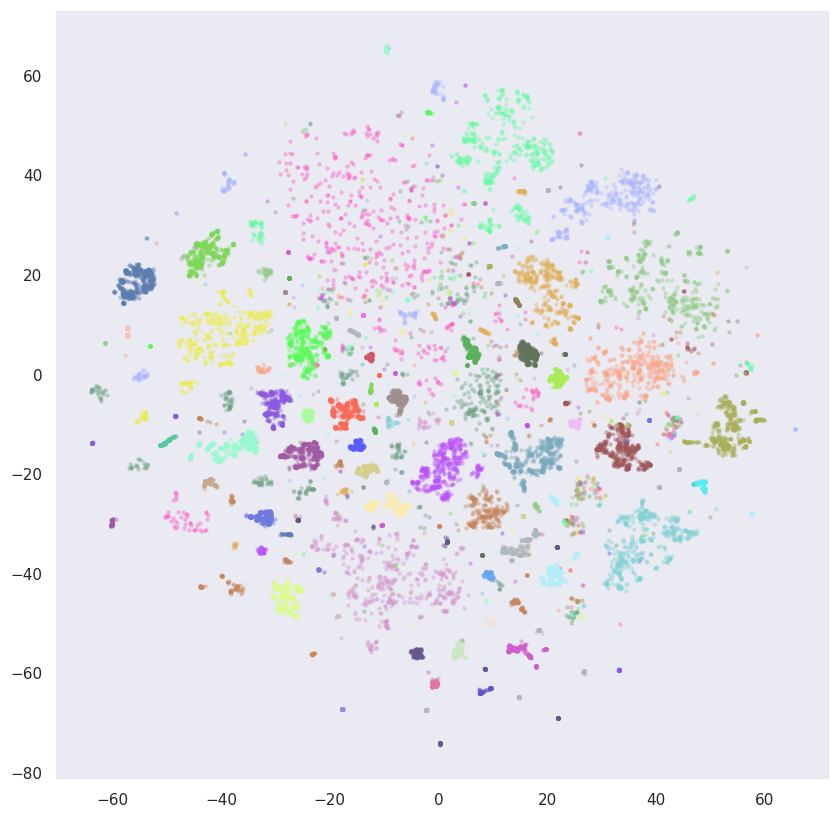

In [22]:
colors = distinctipy.get_colors(len(embedding_labels.unique()), pastel_factor=0.5)

plt.figure(figsize=(10, 10))

for i, label in enumerate(embedding_labels.unique()):
    vecs_ = emb_vecs[embedding_labels == label]
    sample_size = min(len(vecs_), 500)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

# plt.scatter(*centroid_vecs.T, s=250, color='darkgrey', marker='+');

In [50]:
cluster_ids = (embeddings.float() @ centroids.T.float()).argmax(1)
cluster_ids.shape

torch.Size([7185])

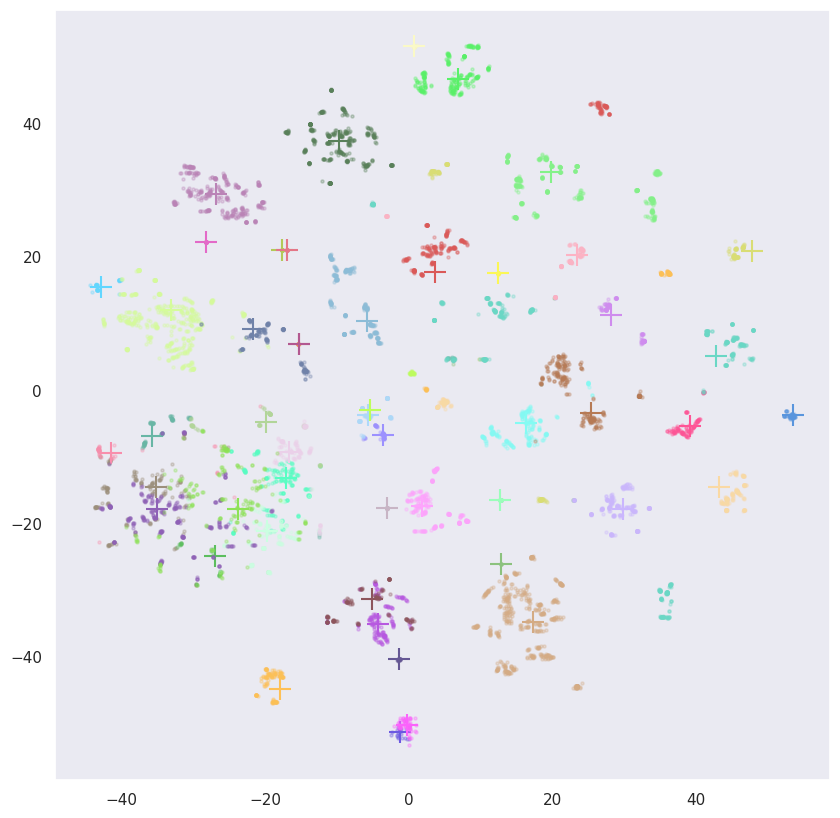

In [59]:
colors = distinctipy.get_colors(len(centroid_vecs), pastel_factor=0.5)

plt.figure(figsize=(10, 10))

for i, centroid in enumerate(centroid_vecs):
    vecs_ = emb_vecs[cluster_ids == i]
    sample_size = min(len(vecs_), 500)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);
    plt.scatter(*centroid.unsqueeze(0).T, color=colors[i], s=250, marker='+');

In [95]:
from ettcl.searching import ColBERTSearcher
from ettcl.core.search import search_dataset

searcher = ColBERTSearcher(None, encoder)
test_dataset = search_dataset(
    test_dataset, searcher, index_path, k=25
)
test_dataset

Setting TOKENIZERS_PARALLELISM=false for forked processes.
Loading cached processed dataset at /home/IAIS/hiser/data/trec-50/test/cache-146419e7e33f6cf0_*_of_00002.arrow


Dataset({
    features: ['text', 'label', 'match_pids', 'match_scores'],
    num_rows: 500
})

In [66]:
test_embeddings = encoder.encode_queries(test_dataset['text'], to_cpu=True)
test_embeddings[0].shape

Encoding:   0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([12, 128])

In [88]:
def get_embeddings(pid: int):
    offset = np.cumsum([0, *doc_lengths])[pid]
    endpos = offset + doc_lengths[pid]
    return embeddings[offset:endpos]

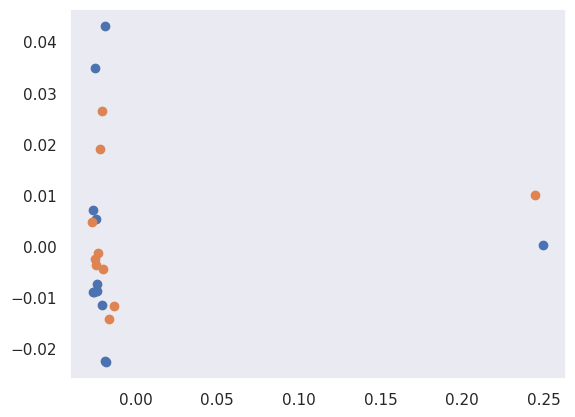

In [96]:
from sklearn.decomposition import PCA

idx = 0
example = test_dataset[idx]

pca = PCA(n_components=2).fit(test_embeddings[idx])

plt.scatter(*pca.transform(test_embeddings[idx]).T);
plt.scatter(*pca.transform(get_embeddings(example['match_pids'][0])).T);

In [98]:
cluster_ids = (embeddings.float() @ centroids.T.float()).argmax(1)
cluster_ids.shape

torch.Size([71002])

In [99]:
cluster_ids.shape, embedding_labels.shape

(torch.Size([71002]), torch.Size([71002]))

In [100]:
from sklearn.metrics import adjusted_rand_score

# Assuming true_labels and kmeans_labels are the true and K-means cluster labels, respectively
ari_score = adjusted_rand_score(embedding_labels, cluster_ids)
ari_score

0.5349561791277481